In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import SubsetRandomSampler

import helper

## Flowers

https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz

In [2]:
import os
import wget

dataurl = "https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz"
basedir = "./data/"

if not os.path.exists(basedir + "flower_data.tar.gz"):
    wget.download(dataurl, basedir)

In [3]:
datadir = "./data/"
subclasses = [0, 10, 20]

datatransforms = {"train": transforms.Compose([transforms.RandomRotation(30),
                                               transforms.Resize(120),
                                                transforms.CenterCrop(120),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.5, 0.5, 0.5], 
                                                                     [0.5, 0.5, 0.5])]),
                   "valid": transforms.Compose([transforms.Resize(120),
                                                transforms.CenterCrop(120),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.5, 0.5, 0.5], 
                                                                     [0.5, 0.5, 0.5])]),
                   "test": transforms.Compose([transforms.Resize(120),
                                               transforms.CenterCrop(120),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.5, 0.5, 0.5], 
                                                                    [0.5, 0.5, 0.5])])}
dirs = {"train": datadir + "train", 
        "valid": datadir + "valid", 
        "test": datadir + "test"}

In [4]:
batchsize = 32

imgsets = {x: datasets.ImageFolder(dirs[x], transform=datatransforms[x]) \
           for x in ["train", "valid", "test"]}
loaders = {x: torch.utils.data.DataLoader(imgsets[x], batch_size=batchsize, shuffle=True) \
           for x in ["train", "valid", "test"]}
sizes = {x: len(imgsets[x]) \
         for x in ["train", "valid", "test"]}

print(sizes["train"], sizes["test"], sizes["valid"])

6552 819 818


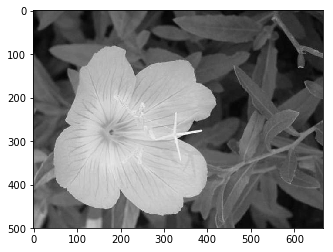

In [12]:
img_path = imgsets["train"].imgs[1][0]
bgr_img = cv2.imread(img_path)
gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
gray_img = gray_img.astype("float32")/255

plt.imshow(gray_img, cmap='gray')
plt.show()
pass;

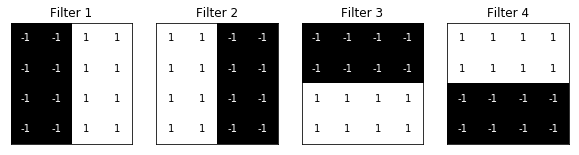

In [13]:
filter_vals = np.array([[-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1], [-1, -1, 1, 1]])

filter_1 = filter_vals
filter_2 = -filter_1
filter_3 = filter_1.T
filter_4 = -filter_3

filters = np.array([filter_1, filter_2, filter_3, filter_4])

fig = plt.figure(figsize=(10, 5))
for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))
    width, height = filters[i].shape
    for x in range(width):
        for y in range(height):
            ax.annotate(str(filters[i][x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if filters[i][x][y]<0 else 'black')
pass;

In [14]:
class Net(nn.Module):
    
    def __init__(self, weight):
        super(Net, self).__init__()
        k_height, k_width = weight.shape[2:]
        self.conv = nn.Conv2d(1, 4, kernel_size=(k_height, k_width), bias=False)
        
        # this determines the filter weight
        self.conv.weight = torch.nn.Parameter(weight)

    def forward(self, x):
        conv_x = self.conv(x)
        activated_x = F.relu(conv_x)
        
        return conv_x, activated_x

def viz_layer(layer, n_filters= 4):
    fig = plt.figure(figsize=(20, 20))
    
    for i in range(n_filters):
        ax = fig.add_subplot(1, n_filters, i+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(layer[0,i].data.numpy()), cmap='gray')
        ax.set_title('Output %s' % str(i+1))

In [15]:
weight = torch.from_numpy(filters).unsqueeze(1).type(torch.FloatTensor)
model = Net(weight)

print(model)

Net(
  (conv): Conv2d(1, 4, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


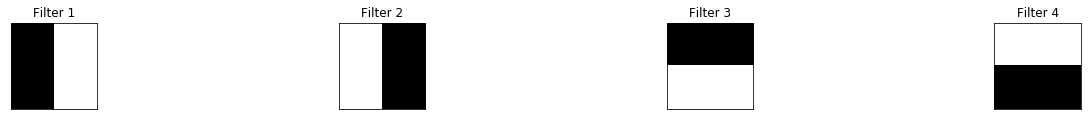

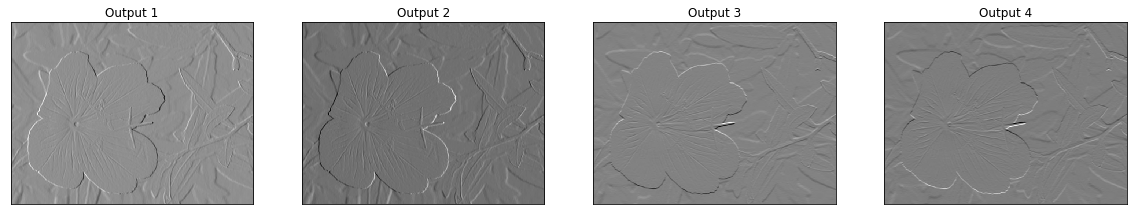

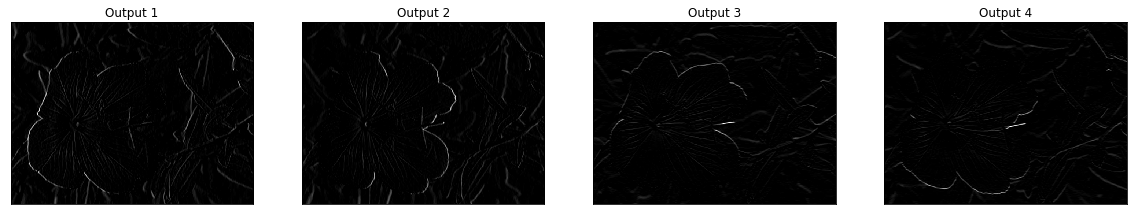

In [16]:
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(left=0, right=1.5, bottom=0.8, top=1, hspace=0.05, wspace=0.05)

for i in range(4):
    ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
    ax.imshow(filters[i], cmap='gray')
    ax.set_title('Filter %s' % str(i+1))

gray_img_tensor = torch.from_numpy(gray_img).unsqueeze(0).unsqueeze(1)

conv_layer, activated_layer = model(gray_img_tensor)

viz_layer(conv_layer)
viz_layer(activated_layer)
pass;